In [ ]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import os

In [ ]:
#!git clone https://github.com/pranjaldatta/SSIM-PyTorch.git

In [ ]:
# mount our Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#get all paths of generated images, a list containing all sub_paths
models = ['wd1_4_anime_default','midjourney_v4_default','midjourney_v5_default','midnight_default','sd21_default']
char_path = ['/content/gdrive/My Drive/2516/onepiece_zoro/' + i for i in models]
total =[]
for path in char_path:
  lst =[]
  for filename in os.listdir(path):
    if filename.endswith("png"): 
        #print(filename)
        lst.append(filename)
  total.append(lst)

#Assign sub-paths to each model
wd1_4_anime_default = total[0]
midjourney_v4_default = total[1]
midjourney_v5_default = total[2]
midnight_default = total[3]
sd21_default = total[4]

#get all paths of target images
targets_path = '/content/gdrive/My Drive/2516/onepiece_zoro/target' 
target = []
for filename in os.listdir(targets_path):
    if filename.endswith("jpg"): 
        #print(filename)
        target.append(filename)

# SSIM
#### Closer to 1 ==> more similar

In [ ]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

In [ ]:
gauss_dis = gaussian(11, 1.5)
print("Distribution: ", gauss_dis)
print("Sum of Gauss Distribution:", torch.sum(gauss_dis))

window = create_window(11, 3)
print("Shape of gaussian window:", window.shape)

Distribution:  tensor([0.0010, 0.0076, 0.0360, 0.1094, 0.2130, 0.2660, 0.2130, 0.1094, 0.0360,
        0.0076, 0.0010])
Sum of Gauss Distribution: tensor(1.)
Shape of gaussian window: torch.Size([3, 1, 11, 11])


In [ ]:
# helper function to load images
load_images = lambda x: np.asarray(Image.open(x).resize((512, 512))) 

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs 
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (512, 512))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

In [ ]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),
    pad = window_size // 2
    
    try:
        lengths, channels, height, width = img1.shape
    except:
        height, width, channels = img1.shape    ###

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
        
    if full:
        return ret, contrast_metric

    return ret


In [ ]:
#prepare each target image for calculating ssim 
temp =[]
target_path = ['/content/gdrive/My Drive/2516/onepiece_zoro/'+'target/'+i for i in target]
for i in target_path:
  target_i = load_images(i)
  _target_i= tensorify(target_i)
  temp.append(_target_i)
_targets = torch.cat(temp, 0)  #concat batchs

#print(_targets.shape)  #check size

In [ ]:
def model_ssim(model_used,model_name_str):
  temp =[]
  all_paths = ['/content/gdrive/My Drive/2516/onepiece_zoro/'+ model_name_str +'/' + i for i in model_used]
  for i in all_paths:
    imag_i = load_images(i)
    if len(imag_i.shape) > 2 and imag_i.shape[2] == 4:
    #slice off the alpha channel
      imag_i = imag_i[:, :, :3]

    _imag_i= tensorify(imag_i)
    temp.append(_imag_i)
  _images = torch.cat(temp, 0)   #concat batchs

  ssim_i = ssim(_targets, _images, val_range=255)
  return ssim_i

wd1_4_anime_default = total[0]
midjourney_default = total[1]
midnight_default = total[2]
sd21_default = total[3]

In [ ]:
wd1_4_anime_default_ssim = model_ssim(wd1_4_anime_default,'wd1_4_anime_default')
midjourney_v4_default_ssim = model_ssim(midjourney_v4_default,'midjourney_v4_default')
midjourney_v5_default_ssim = model_ssim(midjourney_v5_default,'midjourney_v5_default')
midnight_default_ssim = model_ssim(midnight_default,'midnight_default')
sd21_default_ssim = model_ssim(sd21_default,'sd21_default')

print('wd1_4_anime_default_ssim:',wd1_4_anime_default_ssim.item())
print('midjourney_v4_default_ssim:',midjourney_v4_default_ssim.item())
print('midjourney_v5_default_ssim:',midjourney_v5_default_ssim.item())
print('midnight_default_ssim:',midnight_default_ssim.item())
print('sd21_default_ssim:',sd21_default_ssim.item())

wd1_4_anime_default_ssim: 0.24412640929222107
midjourney_v4_default_ssim: 0.37575408816337585
midjourney_v5_default_ssim: 0.6392619609832764
midnight_default_ssim: 0.4409690201282501
sd21_default_ssim: 0.31562337279319763


In [ ]:
#check target_to_target ssim score = 1 or not
ssim_self = model_ssim(target,'target')
print('self_ssim:',ssim_self.item())

self_ssim: 1.0


#  Frechet Inception Distance (FID)
* A metric that calculates the distance between feature vectors calculated for real and generated images.
* Closer to 0 ==> more similar

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
import tensorflow as tf
import cv2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
import keras
from skimage.transform import resize

In [ ]:
def get_batch(model_used,model_name):
  lst = []
  for name in model_used:
    i = cv2.imread('/content/gdrive/My Drive/2516/onepiece_zoro/'+ model_name + name) 
    i = i.astype('float32')   # convert integer to floating point values
    i = resize(i, (512, 512, 3), 0)      #double check size if needed
    i = tf.expand_dims(i, axis=0)    # add a batch dimension
    lst.append(i)
  batch_name = tf.concat(lst, 0)  # concat batches
  print(batch_name.shape)
  batch_name = preprocess_input(batch_name)
  return batch_name

In [ ]:
wd1_4_anime_default_batch = get_batch(wd1_4_anime_default,'wd1_4_anime_default/')
midjourney_v4_default_batch = get_batch(midjourney_v4_default,'midjourney_v4_default/')
midjourney_v5_default_batch = get_batch(midjourney_v5_default,'midjourney_v5_default/')
midnight_default_batch = get_batch(midnight_default,'midnight_default/')
sd21_default_batch = get_batch(sd21_default,'sd21_default/')
target_batch = get_batch(target,'target/')

(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)


In [ ]:
def calculate_fid(model, images1, images2):
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  print(act1.shape, act2.shape)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

In [ ]:
import pandas as pd
model = InceptionV3(include_top=False, pooling='avg', input_shape=(512, 512, 3))

fid_wd1_4_anime_default = calculate_fid(model, wd1_4_anime_default_batch,target_batch)
fid_midjourney_v4_default = calculate_fid(model, midjourney_v4_default_batch,target_batch)
fid_midjourney_v5_default = calculate_fid(model, midjourney_v5_default_batch,target_batch)
fid_midnight_default = calculate_fid(model, midnight_default_batch,target_batch)
fid_sd21_default = calculate_fid(model, sd21_default_batch,target_batch)

print('fid_wd1_4_anime_default: %.3f' % fid_wd1_4_anime_default)
print('fid_midjourney_v4_default: %.3f' % fid_midjourney_v4_default)
print('fid_midjourney_v5_default: %.3f' % fid_midjourney_v5_default)
print('fid_midnight_default: %.3f' % fid_midnight_default)
print('fid_sd21_default: %.3f' % fid_sd21_default)

1/1 [==============================] - 3s 3s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 3s 3s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
fid_wd1_4_anime_default: 113.951
fid_midjourney_v4_default: 111.163
fid_midjourney_v5_default: 81.125
fid_midnight_default: 128.231
fid_sd21_default: 129.926


In [ ]:
#check target_to_target fid score = 0 or not
fid_self = calculate_fid(model, target_batch,target_batch)
print('fid_self: %.3f' % fid_self)

1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
fid_self: -0.000


# Results

In [ ]:
# store the results in a dataframe
import pandas as pd

result = pd.DataFrame({'FID':[fid_wd1_4_anime_default,fid_midjourney_v4_default,fid_midjourney_v5_default,fid_sd21_default,fid_midnight_default],
                       'SSIM':[wd1_4_anime_default_ssim.item(),midjourney_v4_default_ssim.item(),midjourney_v5_default_ssim.item(),sd21_default_ssim.item(),midnight_default_ssim.item()]},
                      index = ['wd1_4_anime','Midjourney_V4','Midjourney_V5','SD21','Midnight'])
result = result.round(decimals=3)
result

,FID,SSIM
wd1_4_anime,113.951,0.244
Midjourney_V4,111.163,0.376
Midjourney_V5,81.125,0.639
SD21,129.926,0.316
Midnight,128.231,0.441


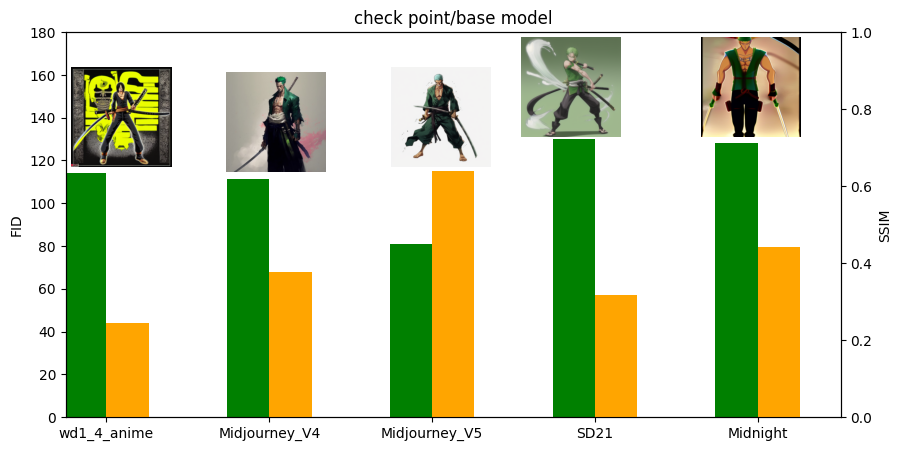

In [ ]:
import matplotlib.pyplot as plt
#from matplotlib.offsetbox import AnnotationBbox, OffSetImage
#from matplotlib._png import read_png

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.26

result.FID.plot(kind='bar', color='green', ax=ax, width=width, position=1,rot= 0) #smaller ==> better
result.SSIM.plot(kind='bar', color='orange', ax=ax2, width=width, position=0,rot= 0) #larger

ax.set_ylim(0,180)
ax.set_ylabel('FID')

ax2.set_ylim(0,1)
ax2.set_ylabel('SSIM')
plt.title('check point/base model')

#models = ['wd1_4_anime_default','midjourney_default','midnight_default','sd21_default']
im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/wd1_4_anime_default/00012-3891654834.png')
newax = fig.add_axes([0.08,0.61,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/midjourney_v4_default/zo_Roronoa_Zoro_One_piece_katana_full_body_92a7e774-da47-478f-95ee-b26726e0d075.png')
newax = fig.add_axes([0.235,0.6,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/midjourney_v5_default/zo_Roronoa_Zoro_katana_full_body_df1e56ae-5953-4656-a91f-83bd8e8ae575.png')
newax = fig.add_axes([0.4,0.61,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/midnight_default/00022-1336937661.png')
newax = fig.add_axes([0.53,0.67,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')


im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/sd21_default/00005-1876603470.png')
newax = fig.add_axes([0.71,0.671,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

plt.show()

# Midnight. Fine-tune.
* 1. Midnight + Lora
* 2. Midnight + Lora + parameters(cfg:7 => 9, sampling steps: 20 => 50, sampling method: Euler a => DPM++2M Karras)
* 3. Midnight + Lora + parameters + Clip skip(1 => 2) 
* 4. Midnight + Lora + parameters + Clip skip + VAE
* 5. Midnight + Lora + parameters + Clip skip + VAE + Prompt （pos/neg)
* 6. Midnight + Lora + parameters + Clip skip + VAE + Prompt + Controlnet
* 7. Midnight + Lora + parameters + Clip skip + VAE + Prompt + Controlnet + background removal

### SSIM

In [ ]:
#get all paths of generated images, a list containing all sub_paths
models = ['mn_1','mn_2','mn_3','mn_4','mn_5','mn_6','mn_7']       ###########
char_path = ['/content/gdrive/My Drive/2516/onepiece_zoro/' + i for i in models]
total =[]
for path in char_path:
  lst =[]
  for filename in os.listdir(path):
    if filename.endswith("png"): 
        #print(filename)
        lst.append(filename)
  total.append(lst)

#Assign sub-paths to each model. ###########
mn_1 = total[0]
mn_2 = total[1]
mn_3 = total[2]
mn_4 = total[3]
mn_5 = total[4]
mn_6 = total[5]
mn_7 = total[6]


In [ ]:
# base Midnight, SSIM=0.441, larger==>better
ssim_mn_1 = model_ssim(mn_1,'mn_1')
ssim_mn_2 = model_ssim(mn_2,'mn_2')
ssim_mn_3 = model_ssim(mn_3,'mn_3')
ssim_mn_4 = model_ssim(mn_4,'mn_4')
ssim_mn_5 = model_ssim(mn_5,'mn_5')
ssim_mn_6 = model_ssim(mn_6,'mn_6')
ssim_mn_7 = model_ssim(mn_7,'mn_7')

print('ssim_mn_1:',ssim_mn_1.item())
print('ssim_mn_2:',ssim_mn_2.item())
print('ssim_mn_3:',ssim_mn_3.item())
print('ssim_mn_4:',ssim_mn_4.item())
print('ssim_mn_5:',ssim_mn_5.item())
print('ssim_mn_6:',ssim_mn_6.item())
print('ssim_mn_7:',ssim_mn_7.item())

ssim_mn_1: 0.4461401700973511
ssim_mn_2: 0.4394358992576599
ssim_mn_3: 0.4941764771938324
ssim_mn_4: 0.4684525728225708
ssim_mn_5: 0.5121966600418091
ssim_mn_6: 0.5797385573387146
ssim_mn_7: 0.6685240864753723


### FID

In [ ]:
# base Midnight,FID=128.231, smaller==>better
batch_mn_1 = get_batch(mn_1,'mn_1/')  ############
batch_mn_2 = get_batch(mn_2,'mn_2/')
batch_mn_3 = get_batch(mn_3,'mn_3/')
batch_mn_4 = get_batch(mn_4,'mn_4/')
batch_mn_5 = get_batch(mn_5,'mn_5/')
batch_mn_6 = get_batch(mn_6,'mn_6/')
batch_mn_7 = get_batch(mn_7,'mn_7/')

model = InceptionV3(include_top=False, pooling='avg', input_shape=(512, 512, 3))

fid_mn_1 = calculate_fid(model, batch_mn_1,target_batch)  ############
fid_mn_2 = calculate_fid(model, batch_mn_2,target_batch)
fid_mn_3 = calculate_fid(model, batch_mn_3,target_batch)
fid_mn_4 = calculate_fid(model, batch_mn_4,target_batch)
fid_mn_5 = calculate_fid(model, batch_mn_5,target_batch)
fid_mn_6 = calculate_fid(model, batch_mn_6,target_batch)
fid_mn_7 = calculate_fid(model, batch_mn_7,target_batch)

print('fid_mn_1: %.3f' % fid_mn_1)
print('fid_mn_2: %.3f' % fid_mn_2)
print('fid_mn_3: %.3f' % fid_mn_3)
print('fid_mn_4: %.3f' % fid_mn_4)
print('fid_mn_5: %.3f' % fid_mn_5)
print('fid_mn_6: %.3f' % fid_mn_6)
print('fid_mn_7: %.3f' % fid_mn_7)

(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
(5, 512, 512, 3)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 5s 5s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 5s 5s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 3s 3s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
1/1 [==============================] - 2s 2s/step
(5, 2048) (5, 2048)
fid_mn_1: 109.082
fid_mn_2: 119.251
fid_mn_3: 92.901
fid_mn_4: 88.698
fid_mn_5: 95.607
fid_mn_6: 78.622
fid_mn_7: 67.217


# Results

In [ ]:
result_tunning = pd.DataFrame({'FID':[fid_mn_1,fid_mn_2,fid_mn_3,fid_mn_4,fid_mn_5,fid_mn_7],
                       'SSIM':[ssim_mn_1.item(),ssim_mn_2.item(),ssim_mn_3.item(), ssim_mn_4.item(),ssim_mn_5.item(),ssim_mn_7.item()]},
                       index = ['Fine-tune\nwith lora', 'Fine-tune\nwith parameters', 'Fine-tune\nwith clip-skip', 'Fine-tune\nwith VAE', 'Fine-tune\nwith extra prompt', 'Fine-tune\nwith controlnet'])
result_tunning = result_tunning.round(decimals=3)
result_tunning

,FID,SSIM
Fine-tune\nwith lora,109.082,0.446
Fine-tune\nwith parameters,119.251,0.439
Fine-tune\nwith clip-skip,92.901,0.494
Fine-tune\nwith VAE,88.698,0.468
Fine-tune\nwith extra prompt,95.607,0.512
Fine-tune\nwith controlnet,67.217,0.669


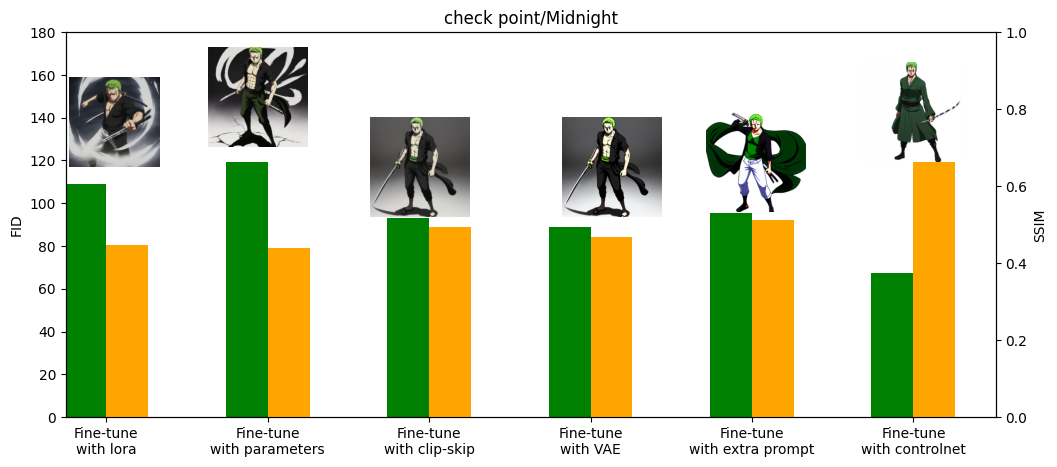

In [ ]:
fig = plt.figure(figsize=(12,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.26

result_tunning.FID.plot(kind='bar', color='green', ax=ax, width=width, position=1,rot= 0) #smaller ==> better
result_tunning.SSIM.plot(kind='bar', color='orange', ax=ax2, width=width, position=0,rot= 0) #larger

ax.set_ylim(0,180)
ax.set_ylabel('FID')

ax2.set_ylim(0,1)
ax2.set_ylabel('SSIM')
plt.title('check point/Midnight')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_1/00008-262911760.png')
newax = fig.add_axes([0.075,0.61,0.18,0.18], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_2/00007-262911760.png')
newax = fig.add_axes([0.185,0.65,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_3/00006-262911760.png')
newax = fig.add_axes([0.32,0.51,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_4/00005-262911760.png')
newax = fig.add_axes([0.48,0.51,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_5/00075-262911760.png')
newax = fig.add_axes([0.6,0.52,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

# im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_6/00002-262911760.png')
# newax = fig.add_axes([0.63,0.56,0.2,0.2], zorder=1)
# newax.imshow(im)
# newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_7/7191E592-22E2-4A7C-8D5B-D5B9261A47A4.png')
newax = fig.add_axes([0.73,0.62,0.2,0.2], zorder=1)
newax.imshow(im)
newax.axis('off')

plt.show()

# combined results

In [192]:
result_combined = pd.concat([result,result_tunning])
result_combined = result_combined.iloc[1:,:]
result_combined = result_combined.round(decimals=2)
result_combined

,FID,SSIM
Midjourney_V4,111.16,0.38
Midjourney_V5,81.12,0.64
SD21,129.93,0.32
Midnight,128.23,0.44
Fine-tune\nwith lora,109.08,0.45
Fine-tune\nwith parameters,119.25,0.44
Fine-tune\nwith clip-skip,92.90,0.49
Fine-tune\nwith VAE,88.70,0.47
Fine-tune\nwith extra prompt,95.61,0.51
Fine-tune\nwith controlnet,67.22,0.67


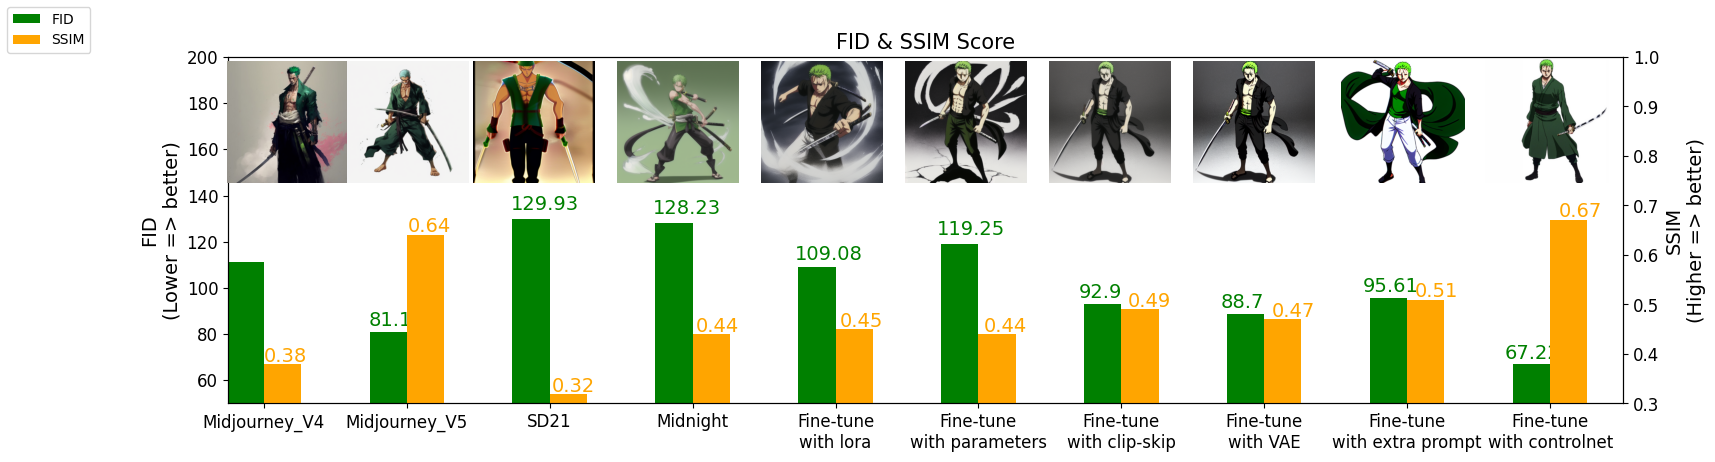

In [220]:
fig = plt.figure(figsize=(18,4.5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.26

fid = result_combined.FID.plot(kind='bar', color='green', ax=ax, width=width, position=1,rot= 0,label ='FID',fontsize=12) #smaller ==> better
ssim = result_combined.SSIM.plot(kind='bar', color='orange', ax=ax2, width=width, position=0,rot= 0, label ='SSIM',fontsize=12) #larger

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()* 0.993 , p.get_height() * 1.03),fontsize=14, color='green')

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x()* 1.007 , p.get_height() * 1.01),fontsize=14, color='orange')

fig.legend(loc="upper left")
ax.set_ylim(50,200)
ax.set_ylabel('FID\n(Lower => better)', fontsize=14)


ax2.set_ylim(0.3,1)
ax2.set_ylabel('SSIM\n(Higher => better)',fontsize=14)
plt.title('FID & SSIM Score',fontsize=15)


im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/midjourney_v4_default/zo_Roronoa_Zoro_One_piece_katana_full_body_92a7e774-da47-478f-95ee-b26726e0d075.png')
newax = fig.add_axes([0.023,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/midjourney_v5_default/zo_Roronoa_Zoro_katana_full_body_df1e56ae-5953-4656-a91f-83bd8e8ae575.png')
newax = fig.add_axes([0.09,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')


im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/sd21_default/00005-1876603470.png')
newax = fig.add_axes([0.16,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')


im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/midnight_default/00022-1336937661.png')
newax = fig.add_axes([0.24,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')



#### 

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_1/00008-262911760.png')
newax = fig.add_axes([0.32,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_2/00007-262911760.png')
newax = fig.add_axes([0.40,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_3/00006-262911760.png')
newax = fig.add_axes([0.48,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_4/00005-262911760.png')
newax = fig.add_axes([0.56,0.6,0.27,0.27], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_5/00075-262911760.png')
newax = fig.add_axes([0.64,0.6,0.275,0.275], zorder=1)
newax.imshow(im)
newax.axis('off')

im = plt.imread('/content/gdrive/My Drive/2516/onepiece_zoro/mn_7/7191E592-22E2-4A7C-8D5B-D5B9261A47A4.png')
newax = fig.add_axes([0.72,0.6,0.275,0.275], zorder=1)
newax.imshow(im)
newax.axis('off')

plt.show()